 # Opis notatnika
 Czas na analizę oraz eksplorację danych.
 
 Eksplorację zaczynam od centralnej bazy danych `flight`, w której przeanalizuję w szczególności zmienną `dep_delay` (za dokumentacją u [źródła](https://www.kaggle.com/datasets/threnjen/2019-airline-delays-and-cancellations?resource=download&select=raw_data_documentation.txt)), która informuje o wysokości opóźnienia odlotu samolotu.
 Wykonując kolejne kroki, najpierw odpowiednio przygotuję wyjściowy zbiór do analizy, by później zacząć go wzbogacać o dodatkowe informacje, np. pogodowe.

 ## Konfiguracja

 Import wymaganych bibliotek

In [58]:
import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy.engine import URL
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

 ## Połączenie z bazą danych
 Konfiguracja połączenia

In [59]:
username = 'postgres'
password = '****'

host = 'localhost'
database = 'airlines'
port= '5432'

 Tworzę zmienne `url` oraz `engine`

In [60]:
url = URL.create(
    "postgresql",
    username=username,
    password=password,
    host=host,
    port=port,
    database=database,
)
engine = create_engine(url)

 Implementacja metody `read_sql_table`, która przyjmuje jeden argument:
 * `table_name` - nazwa ramki na bazie.

In [61]:
def read_sql_table(table_name):
    df = pd.read_sql(f"SELECT * FROM {table_name}", engine)
    return df

 ## Wczytanie danych do obszaru roboczego

> Używając metody `read_sql_table`, wczytuję do obszaru roboczego zawartośc tabeli `flight` i zapisuję w ramce o nazwie `flight_df_raw`.

In [62]:
flight_df_raw = read_sql_table('flight')

In [63]:
flight_df_raw.head()

,id,month,day_of_month,day_of_week,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,dest_airport_id,crs_dep_time,...,crs_elapsed_time,actual_elapsed_time,distance,distance_group,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,year
0,1,1,20,7,WN,N204WN,682,10397,11292,605,...,205.0,204.0,1199.0,5,NaN,NaN,NaN,NaN,NaN,2019
1,2,1,20,7,WN,N8682B,2622,10397,11292,2120,...,210.0,205.0,1199.0,5,NaN,NaN,NaN,NaN,NaN,2019
2,3,1,20,7,WN,N717SA,2939,10397,11292,1800,...,210.0,220.0,1199.0,5,4.0,0.0,10.0,0.0,3.0,2019
3,4,1,20,7,WN,N709SW,3848,10397,11292,1355,...,205.0,204.0,1199.0,5,NaN,NaN,NaN,NaN,NaN,2019
4,5,1,20,7,WN,N7864B,1352,10397,11697,1125,...,120.0,124.0,581.0,3,NaN,NaN,NaN,NaN,NaN,2019


In [64]:
flight_df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1386120 entries, 0 to 1386119
Data columns (total 28 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   id                   1386120 non-null  int64  
 1   month                1386120 non-null  int64  
 2   day_of_month         1386120 non-null  int64  
 3   day_of_week          1386120 non-null  int64  
 4   op_unique_carrier    1386120 non-null  object 
 5   tail_num             1375089 non-null  object 
 6   op_carrier_fl_num    1386120 non-null  int64  
 7   origin_airport_id    1386120 non-null  int64  
 8   dest_airport_id      1386120 non-null  int64  
 9   crs_dep_time         1386120 non-null  int64  
 10  dep_time             1347712 non-null  float64
 11  dep_delay_new        1347711 non-null  float64
 12  dep_time_blk         1386120 non-null  object 
 13  crs_arr_time         1386120 non-null  int64  
 14  arr_time             1346730 non-null  float64
 15

> Usuwam z ramki loty, które:
>* odbyły się w 2020 roku,
>* zostały anulowane  

In [65]:
flight_df_raw['year'].unique()

array([2019, 2020], dtype=int64)

In [66]:
flight_df_raw['cancelled'].unique()

array([0., 1.])

In [67]:
flight_df = flight_df_raw[~((flight_df_raw['year'] == 2020) | (flight_df_raw['cancelled'] == 1.))]
flight_df.shape

(1095742, 28)

> Zmieniam nazwę kolumny `dep_delay_new` na `dep_delay`

In [68]:
flight_df = flight_df.rename(columns={'dep_delay_new': 'dep_delay'})

In [69]:
flight_df.columns

Index(['id', 'month', 'day_of_month', 'day_of_week', 'op_unique_carrier',
       'tail_num', 'op_carrier_fl_num', 'origin_airport_id', 'dest_airport_id',
       'crs_dep_time', 'dep_time', 'dep_delay', 'dep_time_blk', 'crs_arr_time',
       'arr_time', 'arr_delay_new', 'arr_time_blk', 'cancelled',
       'crs_elapsed_time', 'actual_elapsed_time', 'distance', 'distance_group',
       'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay',
       'late_aircraft_delay', 'year'],
      dtype='object')

>Wyznaczam:
>* ile kolumn ma tabela `flight_df`, wynik zapisany do zmiennej `flight_df_columns_amount`.  
>* ile wierszy ma tabela `flight_df`, wynik zapisany do zmiennej `flight_df_rows_amount`.

In [70]:
flight_df_columns_amount = flight_df.shape[1]
flight_df_rows_amount = flight_df.shape[0]

 ## Sprawdzenie
 Kody poniżej sprawdzają, czy ta część została poprawnie wykonana

 ### Sprawdzenie liczby kolumn

In [71]:
flight_df_expected_columns_amount = 28
assert flight_df_columns_amount == flight_df_expected_columns_amount, f'Oczekiwano {flight_df_expected_columns_amount} kolumn, otrzymano {flight_df_columns_amount}'

 ### Sprawdzenie liczby wierszy

In [72]:
flight_df_expected_rows_amount = 1095742
assert flight_df_rows_amount == flight_df_expected_rows_amount, f'Oczekiwano {flight_df_expected_rows_amount} wierszy, otrzymano {flight_df_rows_amount}'

 ### Sprawdzenie czy nie zostały w ramce loty z 2020

In [73]:
flight_df_year_test = flight_df.loc[flight_df['year'] == 2020].shape[0]
assert flight_df_year_test == 0, 'W ramce `flight_df` nadal znajdują się loty z 2020 roku'

 ### Sprawdzenie czy nie zostały w ramce loty anulowane

In [74]:
flight_df_cancelled_test = flight_df.loc[flight_df['cancelled'] != 0].shape[0]
assert flight_df_cancelled_test == 0, 'W ramce `flight_df` nadal znajdują się anulowane loty'

 ### Sprawdzenie czy nazwa kolumny została poprawnie zmieniona

In [75]:
assert 'dep_delay' in flight_df.columns, 'Kolumna dep_delay nie została znaleziona w ramce flight_df'

 # Analiza kolumny `dep_delay` cz. 1
 Wyznaczam statystyki opisowe dla zmiennej `dep_delay` i zapisuję do zmiennej `dep_delay_statistics`:
 
 - średnia,
 - mediana,
 - odchylenie standardowe,
 - min, max
 - percentyle `[0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]`

Wyniki zaokrąglam do dwóch miejsc po przecinku.

In [76]:
dep_delay_statistics = flight_df['dep_delay'].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).round(2)
dep_delay_statistics

count    1095742.00
mean          14.77
std           46.49
min            0.00
10%            0.00
25%            0.00
50%            0.00
75%            8.00
90%           42.00
95%           81.00
99%          206.00
max         1959.00
Name: dep_delay, dtype: float64

 ## Sprawdzenie wyników
 Kod poniżej sprawdza, czy ta część została poprawnie wykonana

In [78]:
expected = {'count': 1095742.0, 'mean': 14.77, 'std': 46.49, 
            'min': 0.0, '10%': 0.0, '25%': 0.0, '50%': 0.0, 
            '75%': 8.0, '90%': 42.0, '95%': 81.0, '99%': 206.0, 'max': 1959.0}
dep_delay_statistics_dict = dep_delay_statistics.to_dict()

assert dep_delay_statistics_dict == expected, f'Błąd. Otrzymano wartości : {dep_delay_statistics_dict}'

 # Analiza kolumny `dep_delay` cz. 2
 Przeanalizuję dokładniej kolumnę `dep_delay` tworząc:  
 1. Wykres dla _całej kolumny_ bez zawężania zakresu danych 
 2. Wykres z pominięciem tych wierszy, dla których `dep_delay=0`  
 3. Wykres ucinając dane do percentyla 95% oraz pomijając `dep_delay=0`

Dla wszystkich wykresów tworzę histogram z koszykami co 10 tj. `[0, 10)`, `[10, 20)` i tak dalej.

>1. Wykres dla całej kolumny `dep_delay`

1959


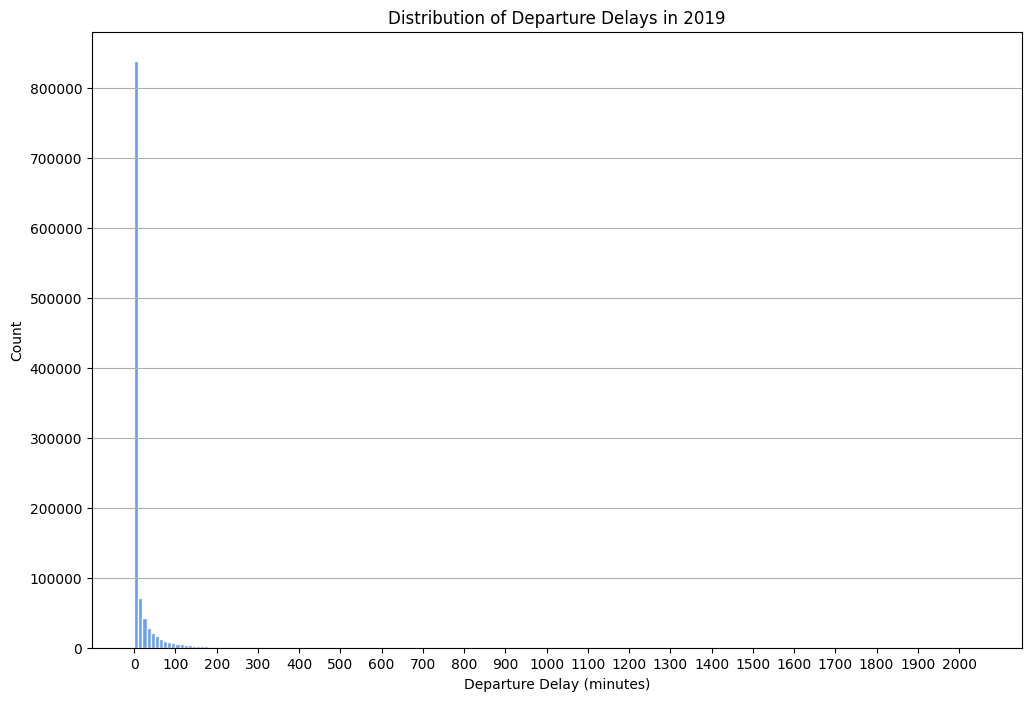

In [79]:
max = int(round(int(flight_df['dep_delay'].max()),0))
print(max)

plt.figure(figsize=(12,8))
plt.hist(flight_df['dep_delay'],
         bins=range(0,max + 100,10),
         edgecolor="white",
         color='#5995ED',
         alpha=0.9,
         )
plt.xticks(range(0,max + 100,100), list(range(0,max + 100,100)))
plt.xlabel('Departure Delay (minutes)')
plt.ylabel('Count')
plt.title('Distribution of Departure Delays in 2019')
plt.grid(visible=True, which='major', axis='y')
plt.show()

>2. Wykres dla `dep_delay` używając warunku `dep_delay > 0`

1959
1


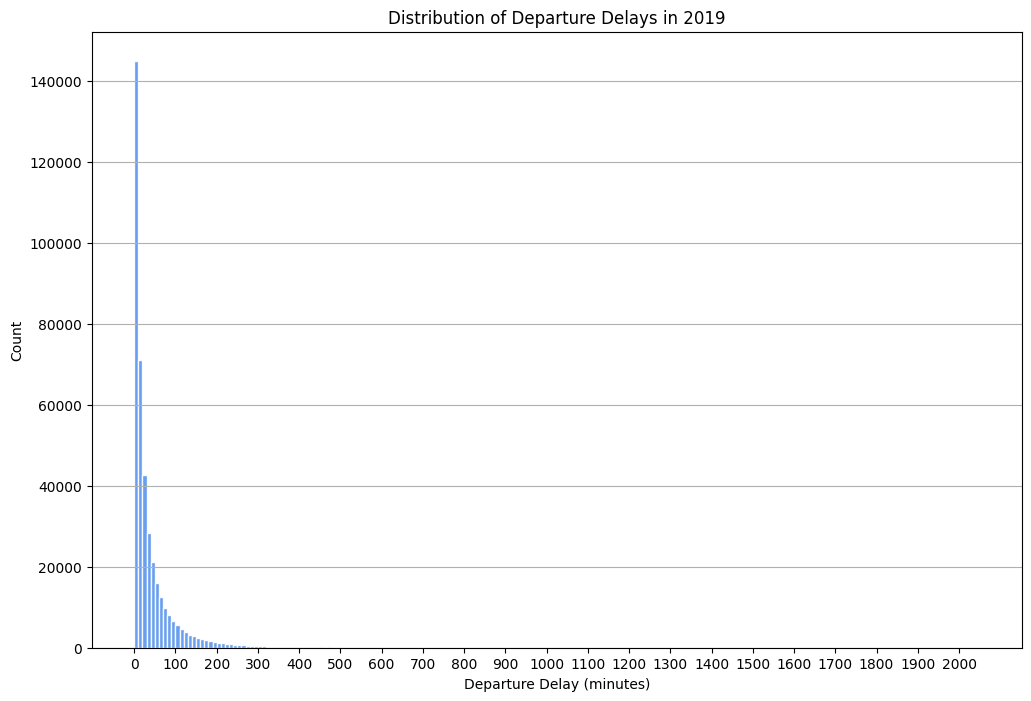

In [80]:
df_dep_delay_no_zero = flight_df[flight_df['dep_delay'] > 0]

max = int(round(int(df_dep_delay_no_zero['dep_delay'].max()),0))
print(max)
min = int(df_dep_delay_no_zero['dep_delay'].min())
print(min)

plt.figure(figsize=(12,8))
plt.hist(df_dep_delay_no_zero['dep_delay'],
         bins=range(0,max + 100,10),
         edgecolor="white",
         color='#5995ED',
         alpha=0.9,
         )
plt.xticks(range(0,max + 100,100), list(range(0,max + 100,100)))
plt.xlabel('Departure Delay (minutes)')
plt.ylabel('Count')
plt.title('Distribution of Departure Delays in 2019')
plt.grid(visible=True, which='major', axis='y')
plt.show()

>3. Wykres dla `dep_delay` używając warunków `dep_delay > 0` oraz `dep_delay < percentile 95%`

79


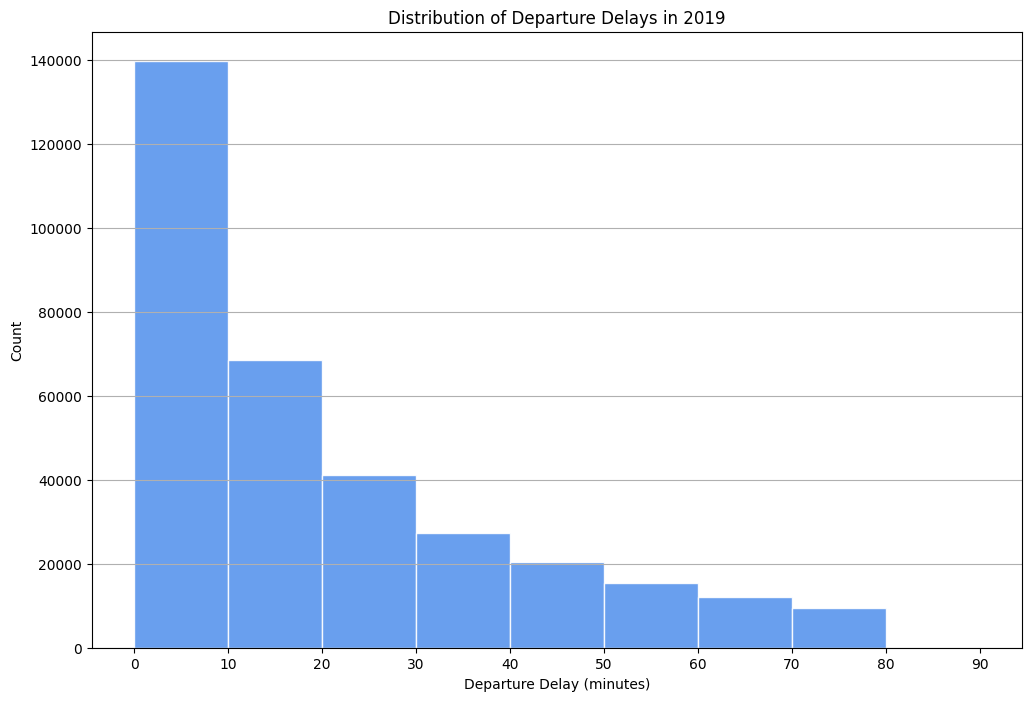

In [114]:
percentile_95 = flight_df['dep_delay'].quantile(0.95)
df_dep_delay_no_zero_perc95 = flight_df[(flight_df['dep_delay'] > 0) & (flight_df['dep_delay'] < percentile_95)]

max = int(round(int(df_dep_delay_no_zero_perc95['dep_delay'].max()),0))
print(max)

plt.figure(figsize=(12,8))
plt.hist(df_dep_delay_no_zero_perc95['dep_delay'],
         bins=range(0,max  + 20,10),
         edgecolor="white",
         color='#5995ED',
         alpha=0.9,
         )
plt.xticks(range(0,max + 20,10), list(range(0,max + 20,10)))
plt.xlabel('Departure Delay (minutes)')
plt.ylabel('Count')
plt.title('Distribution of Departure Delays in 2019')
plt.grid(visible=True, which='major', axis='y')
plt.show()

> **_WNIOSKI_**:
> * Już wstępnie ze statystyk można zaobserwować, że średnia jest większa od mediany, a nawet od 75.percentyla - (wykres skośny prawostronnie) i można uznać że większość lotów nie jest opóźniona
> * Wartość maksymalna sporo odbiega od pozostałych wartości statystyk i znajduje się powyżej 99.percentyla, co stanowi nietypową dla zbioru danych obserwację 
> * Jednak należy się przyjrzeć wszystkim wartościom odstającym w szerszej perspektywie, ponieważ mogą stanowić cenną informację
> * W dalszym kroku decyduję się wykluczyć te opóźnienia które są większe niż 15 minut, i przeanalizuję czy jakiś konkretny czynnik ma wpływ na wielkość opóźnienia.

 # Analiza opóźnień
 1. W ramce `flight_df` tworzę nową kolumnę - `is_delayed` jako te opóźnienia, które wynosiły więcej niż `(>)` 15 minut 
 2. Wyznaczam jaki procent wszystkich lotów był opóźniony -> wynik zapisuję do zmiennej `delayed_ratio` z dokładnością do dwóch miejsc po przecinku.

>1. Tworzę nową kolumnę `is_delayed` używając funkcji `lambda`:

In [83]:
def is_delayed(delay):
    return 1 if delay > 15 else 0

flight_df['is_delayed'] = flight_df['dep_delay'].apply(lambda x: is_delayed(x))

In [84]:
flight_df['is_delayed'].tail(5)

1382982    0
1382983    1
1382984    0
1382985    1
1382986    0
Name: is_delayed, dtype: int64

>2. Definiuję i wyznaczam wartość dla zmiennej `delayed_ratio`

In [115]:
delayed_ratio = flight_df['is_delayed'].mean().round(2)
delayed_ratio

0.19

 ### Sprawdzenie
 Kod poniżej sprawdza, czy ta część została poprawnie wykonana

In [87]:
delayed_ratio_expected = 0.19
assert delayed_ratio == delayed_ratio_expected, f"Oczekiwanio {delayed_ratio_expected}, otrzymano {delayed_ratio}"

 # Opóźnienia vs. miesiąc kalendarzowy
 Chcę teraz zbadać jak zmienia się odsetek opóźnień w zależności od **miesiąca kalendarzowego**

>1. Grupuję dane po miesiącu i zapisuję do ramki `flight_delays_by_month_df`

In [88]:
flight_delays_by_month_df = flight_df.groupby('month')['is_delayed'].mean().round(2).reset_index()
flight_delays_by_month_df

,month,is_delayed
0,1,0.18
1,2,0.22
2,3,0.18
3,4,0.18
4,5,0.20
5,6,0.25
6,7,0.22
7,8,0.21
8,9,0.15
9,10,0.16


In [89]:
flight_delays_by_month_df.columns

Index(['month', 'is_delayed'], dtype='object')

>2. Tworzę wykres, używając danych z ramki `flight_delays_by_month_df`

In [90]:
flight_delays_by_month_plot = px.line(  data_frame=flight_delays_by_month_df,
                                        x='month',
                                        y='is_delayed',
                                        markers=True,
                                        height=600, 
                                        width=1200,
                                        title='Percentage of delays in 2019 by month',
                                        labels={'month': 'Months', 'is_delayed': 'Percentage of delays (%)'},
                                        )

month = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
         'August', 'September', 'October', 'November', 'December']

flight_delays_by_month_plot.update_layout(xaxis = dict( tickvals = [i for i in range(1,13)],
                                                        ticktext = month
                                                        ),
                                         yaxis=dict(range=[0, flight_delays_by_month_df['is_delayed'].max()+0.05], tickformat=".2%"),
                                         hovermode="x", # 'closest' / 'x unified'
                                         hoverlabel=dict(bgcolor="white"),
                                         hoverlabel_align = 'auto'
                                            )
flight_delays_by_month_plot.update_traces(mode="markers+lines", hovertemplate="Month: <b>%{x}</b> <br>Percentage of delays (%): <b>%{y:.2%}</b>", line=dict(color='#5995ED')) # marker=dict(color='#5995ED')

flight_delays_by_month_plot.show()

> **_WNIOSKI_**:
> * Można zaobserwować że największe opóźnienia przypadają na miesiąc czerwiec, co może sugerować że po zakończonym roku szkolnym rodziny z dziećmi wylatują masowo na wakacje
> * Kolejnym miesiącem który wykazuje kolejno najwyższe opóźnienia jest luty. Oto kilka potencjalnych wydarzeń, które mogą mieć wpływ na ruch lotniczy w lutym w USA:
1. **Święto Prezydenta (President's Day)**: to federalne święto obchodzone w trzeci poniedziałek lutego. Wiele osób korzysta z tej okazji, aby wybrać się na krótkie wakacje lub wypad za miasto
2. **Mistrzostwa sportowe:** w lutym odbywają się różne mistrzostwa sportowe, takie jak Super Bowl (w przypadku futbolu amerykańskiego), NBA All-Star Weekend (w przypadku koszykówki) czy Daytona 500 (w przypadku wyścigów samochodowych). Duże wydarzenia sportowe mogą przyciągać fanów z całego kraju i generować wzmożony ruch lotniczy
3. **Targi**: w lutym często odbywają się różne targi książki, targi handlowe i konwencje branżowe, które przyciągają zarówno uczestników, jak i wystawców z różnych części kraju i świata
> * Trzeci z kolei miesiąc to grudzień - bez wątpienia ludzie podróżują żeby spotkać sie na Święta Bożego Narodzenia z rodziną i bliskimi.

 # Opóźnienia vs. dzień tygodnia cz. 1
 Chcę zbadać, jak zmienia się odsetek opóźnień w zależności od **dnia tygodnia**

>1. Grupuję dane po dniu tygodnia i zapisuję do ramki `flight_delays_by_weekday_df`

In [91]:
flight_delays_by_weekday_df = flight_df.groupby('day_of_week')['is_delayed'].mean().round(2).reset_index()
flight_delays_by_weekday_df

,day_of_week,is_delayed
0,1,0.20
1,2,0.17
2,3,0.18
3,4,0.21
4,5,0.20
5,6,0.17
6,7,0.19


>2. Tworzę wykres, używając danych z ramki `flight_delays_by_weekday_df`

In [92]:
flight_delays_by_weekday_plot = px.line(  data_frame=flight_delays_by_weekday_df,
                                        x='day_of_week',
                                        y='is_delayed',
                                        markers=True,
                                        height=600, 
                                        width=1200,
                                        title='Percentage of delays in 2019 by week',
                                        labels={'day_of_week': 'Day of week', 'is_delayed': 'Percentage of delays (%)'},
                                        )

days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

flight_delays_by_weekday_plot.update_layout(xaxis = dict( tickvals = [i for i in range(1,8)],
                                                        ticktext = days
                                                        ),
                                         yaxis=dict(range=[0, flight_delays_by_weekday_df['is_delayed'].max()+0.05], tickformat=".2%"),
                                         hovermode="x", # 'closest' / 'x unified'
                                         hoverlabel=dict(bgcolor="white"),
                                         hoverlabel_align = 'auto'
                                            )
flight_delays_by_weekday_plot.update_traces(mode="markers+lines", hovertemplate="Day of week: <b>%{x}</b> <br>Percentage of delay (%): <b>%{y:.2%}</b>", line=dict(color='#5995ED')) # marker=dict(color='#5995ED')

flight_delays_by_weekday_plot.show()

> **_WNIOSKI_**:
> * Największe opóźnienia przypadają na czwartek, piątek i poniedziałek (mogą to być dni podróży biznesowych jak i turystycznych), jednak różnica punków procentowych nie jest zbyt duża w porównaniu do pozostałych dni tygodnia. 


 # Opóźnienia vs. dzień tygodnia cz. 2
 W tym kroku chcę zobaczyć jak rozkłada się podział procentowy na dni robocze i weekend. 

>1. Dodaję nową kolumnę `is_weekend` do `flight_df`. Jako weekend przyjmuję wartości 6, 7.

In [93]:
def is_weekend(day):
    return 1 if day in [6, 7] else 0

flight_df['is_weekend'] = flight_df['day_of_week'].apply(lambda x: is_weekend(x))

>2. Agreguję dane do ramki `flight_delays_by_weekend_df`

In [94]:
flight_delays_by_weekend_df = flight_df.groupby('is_weekend')['is_delayed'].mean().round(2)
flight_delays_by_weekend_df

is_weekend
0    0.19
1    0.18
Name: is_delayed, dtype: float64

>3. Tworzę wykres używając danych z ramki `flight_delays_by_weekend_df`

In [95]:
flight_delays_by_weekend_plot = px.bar(
                                        y=flight_delays_by_weekend_df,
                                        height=600, 
                                        width=600,
                                        text_auto=True,
                                        title='Percentage of delays in 2019 by weekend',
                                        labels={'x': 'Day of the week (weekday/weekend)', 'y': 'Percentage of delays (%)'},
                                        )

days = ['Weekday', 'Weekend']

flight_delays_by_weekend_plot.update_layout(xaxis = dict( tickvals = [0,1],
                                                        ticktext = days
                                                        ),
                                         yaxis=dict(range=[0, flight_delays_by_weekend_df.max()+0.05], tickformat=".2%"),
                                         hovermode="x", # 'closest' / 'x unified'
                                         hoverlabel=dict(bgcolor="white"),
                                         hoverlabel_align = 'auto'
                                            )
flight_delays_by_weekend_plot.update_traces(hovertemplate="Day of week (weekday/weekend): <b>%{x}</b> <br>Percentage of delay (%): <b>%{y:.2%}</b>", marker=dict(color='#5995ED'), textposition='outside')

flight_delays_by_weekend_plot.show()

> **_WNIOSKI_**:
> * Różnica w opóźnieniach między tygodniem roboczym a weekendem to tylko 1 punkt procentowy, co oznacza że opóźnienia mają miejsce bez względu na badaną kategorię.

 ### Sprawdzenie
 Kod poniżej sprawdza, czy ta część została poprawnie wykonana

In [96]:
expected_flight_df_by_weekend = {0: 0.19, 1: 0.18}
assert flight_delays_by_weekend_df.to_dict(
) == expected_flight_df_by_weekend, f'Spodziewano się wyników: {expected_flight_df_by_weekend}\n otrzymano  {flight_delays_by_weekend_df}'

 # Analiza kolumny `distance`  
  Wyznaczam statystyki opisowe dla zmiennej `distance` i zapisuję do zmiennej `dep_delay_statistics`:
 
 - średnia,
 - mediana,
 - odchylenie standardowe,
 - min, max
 - percentyle `[0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]`

Wyniki zaokrąglam do dwóch miejsc po przecinku.

 Tutaj dokonaj agregacji danych do ramki `flight_distance_analysis_df`

In [97]:
flight_distance_statistics = flight_df['distance'].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).round(2)
flight_distance_statistics

count    1095742.00
mean         758.08
std          600.43
min          100.00
10%          216.00
25%          337.00
50%          606.00
75%          937.00
90%         1721.00
95%         2475.00
99%         2586.00
max         2586.00
Name: distance, dtype: float64

 # Opóźnienia vs. odległość lotu

> Tworzę wykres dla 10 000 losowych wierszy z tabeli `flight_df`

In [98]:
sample_df = flight_df.sample(n=10000, random_state=1) # te same losowe próbki za każdym razem jak uruchomię kod - utrzymanie spójności wyników

fig = px.scatter(sample_df, 
                 x='distance',
                 y='dep_delay',
                 color='dep_delay',
                 color_continuous_scale=['#5995ED', '#FE5F55'],
                 color_continuous_midpoint=600,
                 title='Departure delay vs. distance (for 10k random flights)',
                 labels={'distance': 'Distance (in miles)', 'dep_delay': 'Delays (in minutes)'},
                )
fig.update_traces(marker_size=10, marker_line_width=0.7, marker_line_color = '#304C89') 
fig.update_layout(xaxis = dict( tickvals = [i for i in range(0, int(sample_df['distance'].max())+250,250)],
                            ),
                  hoverlabel=dict(bgcolor="white"),
                  hoverlabel_align = 'auto'
                                            )
fig.show()

> Usuwam z ramki `flight_df` wiersze, dla których `distance` jest powyżej `95% percentyla` (> 95%)

In [99]:
percentile_95 = flight_df['distance'].quantile(0.95)
flight_df = flight_df[~(flight_df['distance'] > percentile_95)]

flight_df.shape

(1057391, 30)

 ### Sprawdzenie
 Kod poniżej sprawdza, czy ta część została poprawnie wykonana

In [100]:
flight_df_expected_rows_amount = 1057391
flight_df_rows_amount = flight_df.shape[0]

assert flight_df_rows_amount == flight_df_expected_rows_amount, f'Oczekiwano {flight_df_expected_rows_amount} wierszy, otrzymano {flight_df_rows_amount}'

> Dokonuję agregacji zmiennej `distance` co 100 mil do nowej kolumny `distance_agg` oraz wyznaczam odsetek opóźnień w każdym koszyku.

In [101]:
bins = list(range(0, int(flight_df['distance'].max())+100, 100))
flight_df['distance_agg'] = pd.cut(flight_df['distance'], bins=bins)

flight_delays_by_distance_agg_df = flight_df.groupby('distance_agg')['is_delayed'].mean().reset_index()

flight_delays_by_distance_agg_df

C:\Users\ktkat\AppData\Local\Temp\ipykernel_12412\466066696.py:4: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



,distance_agg,is_delayed
0,"(0, 100]",0.059320
1,"(100, 200]",0.168884
2,"(200, 300]",0.181882
3,"(300, 400]",0.195604
4,"(400, 500]",0.171409
5,"(500, 600]",0.165023
6,"(600, 700]",0.197254
7,"(700, 800]",0.235472
8,"(800, 900]",0.211396
9,"(900, 1000]",0.224219


In [102]:
flight_delays_by_distance_agg_df['is_delayed'].fillna(0, inplace=True)

C:\Users\ktkat\AppData\Local\Temp\ipykernel_12412\3883265856.py:1: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





In [103]:
print(flight_delays_by_distance_agg_df['distance_agg'].dtype)

category


In [104]:
flight_delays_by_distance_agg_df['distance_agg'] = flight_delays_by_distance_agg_df['distance_agg'].astype(str)
print(flight_delays_by_distance_agg_df['distance_agg'].dtype)

object


> Tworzę wykres słupkowy używając danych zapisanych w `flight_delays_by_distance_agg_df`

In [105]:
fig = px.bar(data_frame=flight_delays_by_distance_agg_df,
             x='distance_agg',
             y='is_delayed',
             labels={'distance_agg': 'Distance Ranges', 'is_delayed': 'Percentage of Delays (%)'},
             title='Percentage of Delays by Distance Aggregation',
             text_auto=True,
             height=600
            )

fig.update_layout(xaxis_title_standoff=25, 
                  xaxis_tickangle=45, 
                  hoverlabel=dict(bgcolor="white"),
                  hoverlabel_align = 'auto')

fig.update_traces(marker_color='#5995ED',
                  hovertemplate='Distance range: %{x}<br>Percentage of Delays: %{y:.2%}',
                  textposition='outside')

fig.update_yaxes(tickformat='.2%')

fig.show()

> **_WNIOSKI_**:
> * Nie można jednoznacznie stwierdzić, że większy dystans oznacza większe prawdopodobieństwo opóźnienia lotu, choć koszyk odległości **1700-1800 mil** przedstawia największe opóźnienia, jednak tendencja nie jest liniowo wzrostowa a raczej nacechowana sinusoidalnie.


 ### Sprawdzenie
 Kod poniżej sprawdza, czy ta część została poprawnie wykonana

In [106]:
assert 'distance_agg' in flight_df.columns, 'Nie odnaleziono kolumny distance_agg w ramce flight_df'

 # Opóźnienia vs. grupa odległości

> Analizuję kolumnę `distance_group` dostępą w zbiorze danych aby sprawdzić dla jakich odcinków zostały wyznaczone poszczególne grupy. 

In [107]:
flight_df['distance_group'].describe()

count    1.057391e+06
mean     3.172109e+00
std      1.959857e+00
min      1.000000e+00
25%      2.000000e+00
50%      3.000000e+00
75%      4.000000e+00
max      1.000000e+01
Name: distance_group, dtype: float64

In [108]:
flight_df['distance_group'].unique()

array([ 5,  3,  8,  4,  2,  1,  6,  7, 10], dtype=int64)

In [109]:
flight_distance_by_distance_group = flight_df.groupby('distance_group')['distance'].agg(['min', 'max']).reset_index()
flight_distance_by_distance_group

,distance_group,min,max
0,1,100.0,239.0
1,2,255.0,480.0
2,3,544.0,746.0
3,4,762.0,967.0
4,5,1024.0,1235.0
5,6,1389.0,1448.0
6,7,1721.0,1744.0
7,8,1846.0,1947.0
8,10,2475.0,2475.0


> Wyznaczam odsetek opóźnień w każdej grupie zapisując wyniki do ramki `flight_delays_by_distance_group_df`

In [110]:
flight_delays_by_distance_group_df = flight_df.groupby('distance_group')['is_delayed'].mean().reset_index()
flight_delays_by_distance_group_df

,distance_group,is_delayed
0,1,0.158558
1,2,0.187302
2,3,0.198168
3,4,0.216511
4,5,0.196224
5,6,0.189574
6,7,0.206757
7,8,0.235443
8,10,0.166569


> Tworzę wykres przy użyciu ramki `flight_delays_by_distance_group_df` zakłądająćże grupy odległosci są co 250 mil

In [111]:
fig = px.bar(data_frame=flight_delays_by_distance_group_df,
             x='distance_group',
             y='is_delayed',
             labels={'distance_group': 'Distance Group (in miles)', 'is_delayed': 'Probability of Delay (%)'},
             title='Probability of Delay by Distance Group',
             text_auto=True,
             height=600
            )
ranges = ['0 - 250', '251 - 500', '501 - 750', '751 - 1000', '1001 - 1250', '1251 - 1500', '1501 - 1750', '1751 - 2000', '2001 - 2250', '2251 - 2500']
fig.update_layout(hoverlabel=dict(bgcolor="white"),
                  hoverlabel_align = 'auto',
                  xaxis=dict(tickvals=[i for i in range(1,11)], 
                             ticktext=ranges)
                  )

fig.update_traces(marker_color='#5995ED',
                  hovertemplate='Distance group: <b>%{x}</b><br>Probability of Delay: <b>%{y:.2%}</b>',
                  textposition='outside')

fig.update_yaxes(tickformat='.2%')

fig.show()

 ### Czy większy dystans oznacza większe prawdopodobieństwo opóźnenia lotu?

> * Grupując dane po kategoriach odległościowych można zaobserwować bardziej liniową dodatnią tendencję zależności opóźnień od dystansu lotu, chociaż ostatnia grupa ma drugi najniższy wynik opóźnień.
> * Najmniejszy odsetek opóźnień notuje się w grupie z najkrótszym i najdłuższym dystansem

 ## Zapis ramki do pliku csv
 Zapisuje dane z ramki `flight_df` do pliku csv w katalogu `data\processed`

In [112]:
flight_df.to_csv(r"..\data\processed\flight_df_01.csv", index=False)

In [113]:
flight_df.shape

(1057391, 31)

 # Podsumowanie
W tym notatniku dokonałam częściowej analizy danych. W kolejnym wzbogacę ramkę o dodatkowe dane dotyczące roku produkcji samolotów i dokonam dalszej analizy.